In [41]:
# Set Constants
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import spectrogram


sr = 16000  # Sample Rate
duration = 2.5  # Signal Duration in Seconds

# File Paths
FEATURES_CSV = '/home/aditya_tilak/dataset/Rhaphigaster_nebulos_features.csv'
AUDIO_FOLDER = '/mnt/external-disk/InsectSound1000'
INSECT_NAME = 'BRhaphigaster_'

# Step 1: Load and Filter Dataset
df = pd.read_csv(FEATURES_CSV)

# Remove outlier frequencies (values beyond 3 standard deviations)
z_scores = np.abs((df['dominant_freq'] - df['dominant_freq'].mean()) / df['dominant_freq'].std())
df_filtered = df[z_scores <= 3]

df_filtered.columns

Index(['file_path', 'insect_name', 'spectral_centroid', 'spectral_bandwidth',
       'spectral_flatness', 'spectral_contrast', 'rms_energy',
       'zero_crossing_rate', 'temporal_variance', 'chroma', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'mfcc20', 'amplitude', 'dominant_freq'],
      dtype='object')

In [42]:
# Step 2: Analyze and Extract Sound Profile
def extract_sound_profile(df):
    mode_frequency = df.loc[df['dominant_freq'] != 0, 'dominant_freq'].mode()[0]
    mode_amplitude = df['amplitude'].mode()[0]
    profile = {
        "Insect name": df['insect_name'][1],
        "Mode Frequency": mode_frequency,
        "Dominant Frequency Range": (df['dominant_freq'].min(), df['dominant_freq'].max()),
        "Dominant Frequency Mean": df['dominant_freq'].mean(),
        "Dominant Amplitude (Mode)": mode_amplitude,
        "Amplitude Range": (df['amplitude'].min(), df['amplitude'].max()),
        "Spectral Centroid Mean": df['spectral_centroid'].mean(),
        "Spectral Bandwidth Mean": df['spectral_bandwidth'].mean(),
        "RMS Energy Mean": df['rms_energy'].mean(),
        "Zero-Crossing Rate Mean": df['zero_crossing_rate'].mean(),
        "Spectral Flatness Mean": df['spectral_flatness'].mean()
    }
    print("Sound Profile:")
    for k, v in profile.items():
        print(f"{k}: {v}")
    return profile

Sound Profile:
Insect name: Rhaphigaster_nebulos
Mode Frequency: 21.533203125
Dominant Frequency Range: (np.float64(0.0), np.float64(75.3662109375))
Dominant Frequency Mean: 9.591910963713822
Dominant Amplitude (Mode): 0.001372348
Amplitude Range: (np.float64(0.00095800724), np.float64(3.7133443))
Spectral Centroid Mean: 1461.0464024721894
Spectral Bandwidth Mean: 2106.713581080502
RMS Energy Mean: 0.005150472098972279
Zero-Crossing Rate Mean: 0.02436008580557891
Spectral Flatness Mean: 0.00029083146888755624


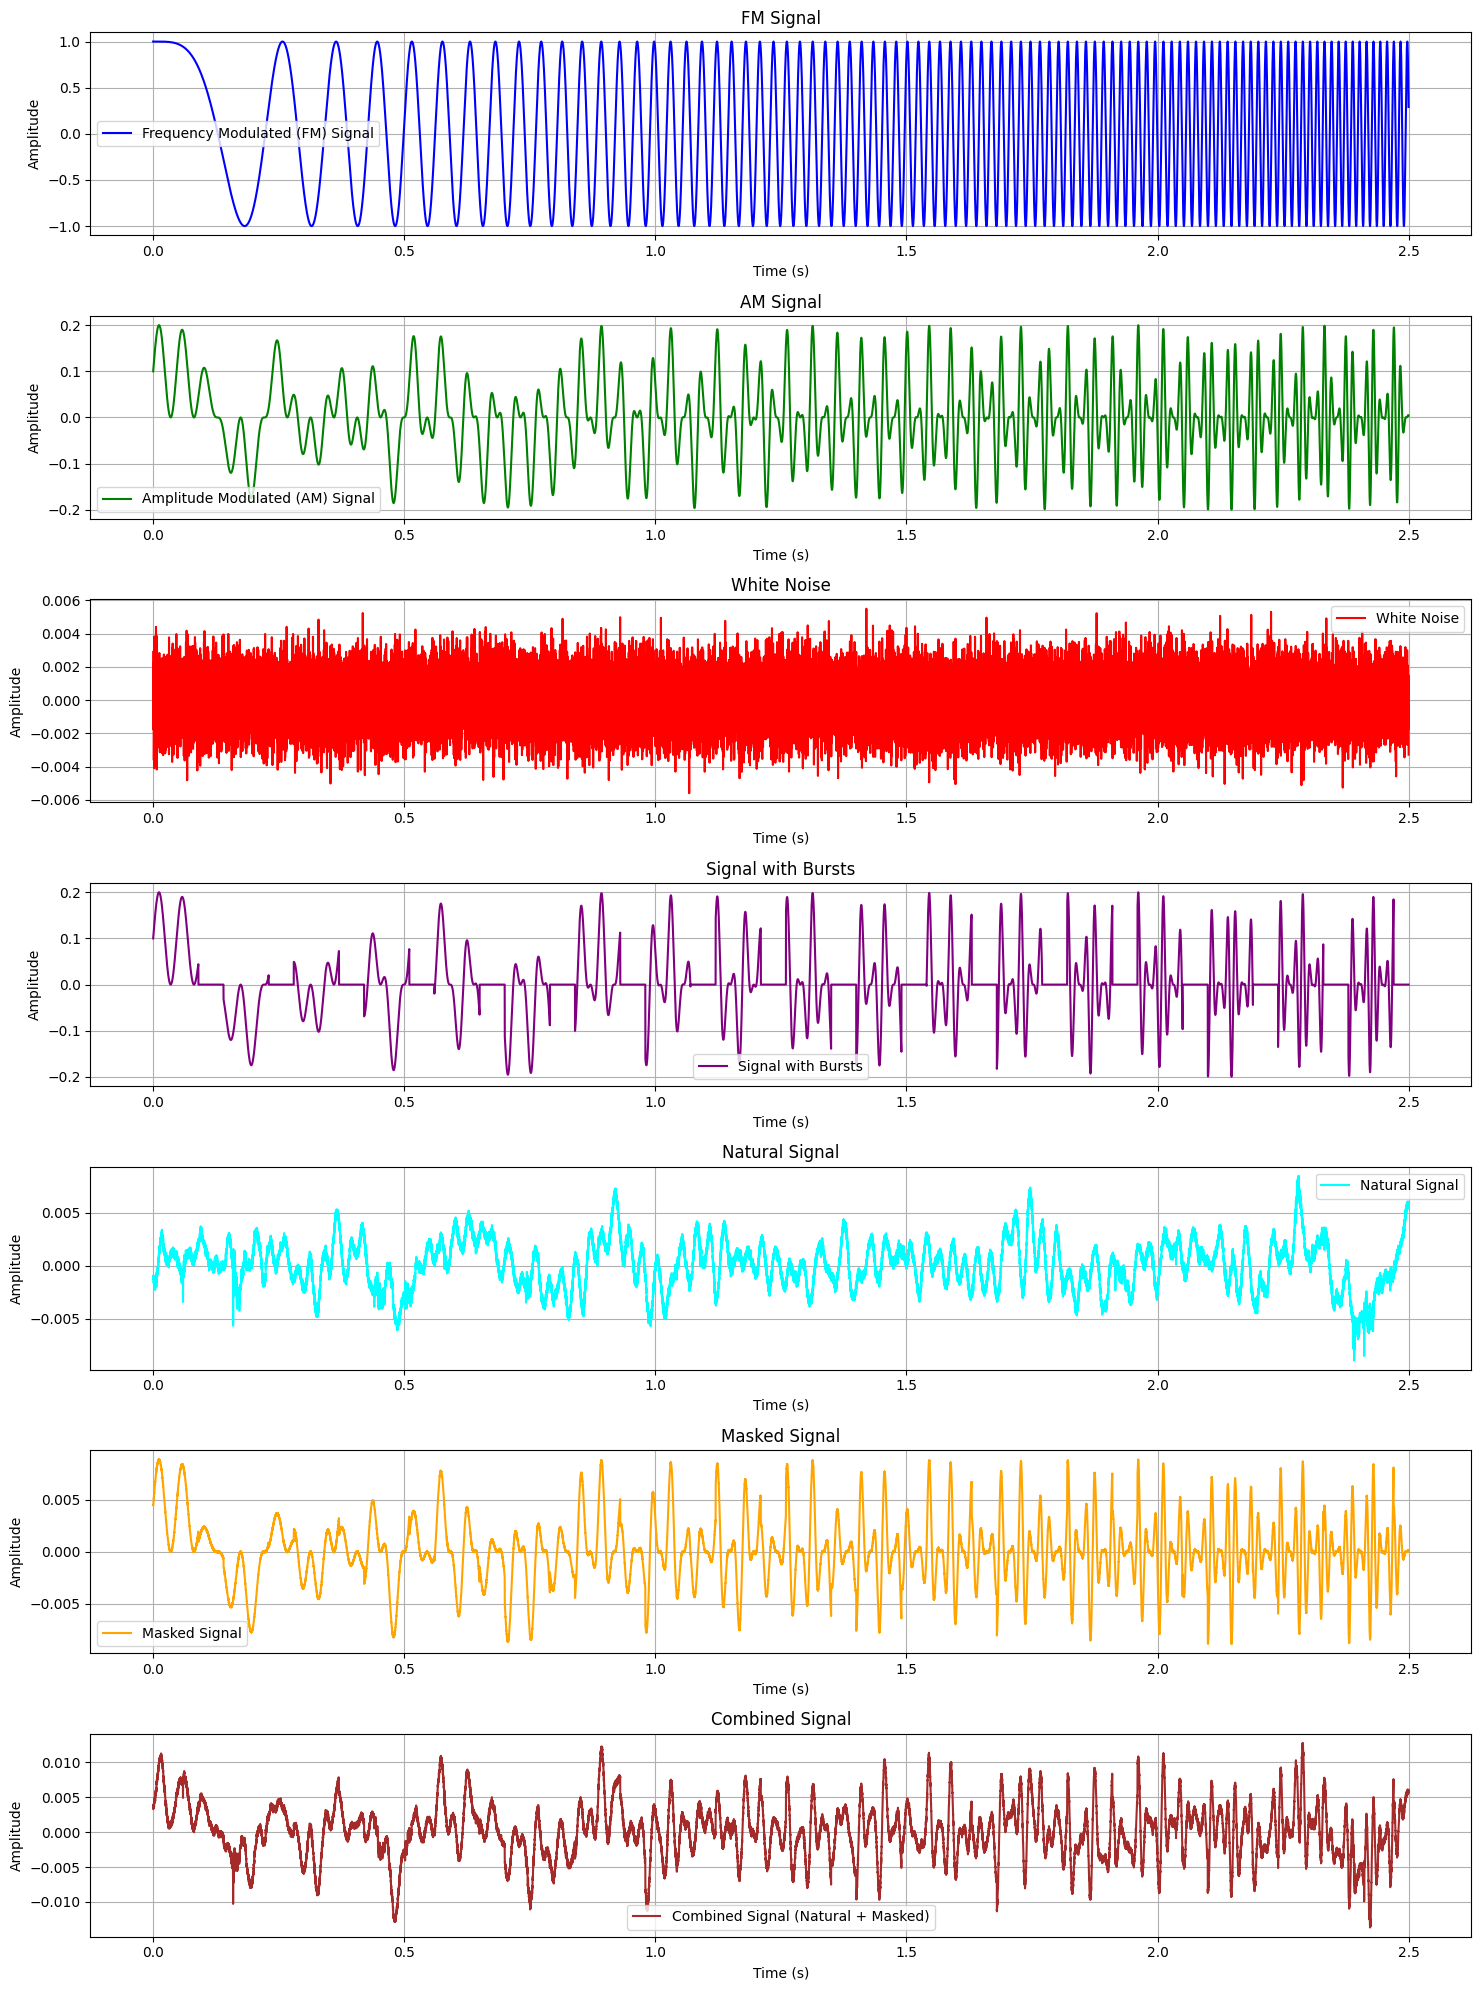

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

# Step 3: Extract parameters dynamically based on the extracted profile
sound_profile = extract_sound_profile(df_filtered)

freq_range = sound_profile["Dominant Frequency Range"]
mode_freq = sound_profile["Mode Frequency"]
dominant_freq_mean = sound_profile["Dominant Frequency Mean"]
amplitude_range = sound_profile["Amplitude Range"]
zero_crossing_rate = sound_profile["Zero-Crossing Rate Mean"]
white_noise_strength = sound_profile["Dominant Amplitude (Mode)"]  # Reduce strength dynamically

# Time parameters
duration = 2.5  # seconds
sr = 16000  # Sampling rate in Hz
t = np.linspace(0, duration, int(sr * duration), endpoint=False)

# Frequency modulation: Chirp signal (linear frequency change)
fm_signal = chirp(
    t, 
    f0=freq_range[0],  # Adjust chirp start frequency
    f1=freq_range[1],  # Adjust chirp end frequency
    t1=duration, 
    method='linear'
)

# Amplitude modulation: Smooth sinusoidal envelope for better alignment
amplitude_modulation = 0.1 + 0.1 * np.sin(2 * np.pi * mode_freq * t)  # Smooth modulation
am_signal = fm_signal * amplitude_modulation

# Generate signal with bursts
NUM_HOPS = 20  # Reduce hops to reduce abruptness
burst_durations = [0.09] * NUM_HOPS  # Slightly longer burst durations
burst_intervals = [0.05] * NUM_HOPS  # Slightly longer intervals
signal_with_bursts = np.zeros(len(t))

start_idx = 0
for interval, duration in zip(burst_intervals, burst_durations):
    end_idx = int(start_idx + duration * sr)
    signal_with_bursts[start_idx:end_idx] = am_signal[start_idx:end_idx]
    start_idx = int(end_idx + interval * sr)

# Generate white noise
white_noise = np.random.normal(0, white_noise_strength, len(t))

# # Apply bandpass filtering to align noise with dominant frequencies
# from scipy.signal import butter, lfilter

# def bandpass_filter(data, lowcut, highcut, fs, order=4):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     return lfilter(b, a, data)

# white_noise = bandpass_filter(white_noise, freq_range[0], freq_range[1], sr)

# Combine AM signal, white noise, and bursts to create masked signal
masked_signal = (am_signal + white_noise + signal_with_bursts)
masked_signal /= np.max(np.abs(masked_signal))  # Normalize

# Truncate or match lengths of natural signal and masked signal
wav_files = [f for f in os.listdir(AUDIO_FOLDER) if f.endswith('.wav') and INSECT_NAME in f]
random_wav_file = wav_files[0]
natural_signal, _ = librosa.load(os.path.join(AUDIO_FOLDER, random_wav_file), sr=sr)
min_length = min(len(masked_signal), len(natural_signal))
natural_signal = natural_signal[:min_length]
masked_signal = masked_signal[:min_length]

# Adjust the combined signal amplitude to match the natural signal for better SSIM
masked_signal *= np.max(np.abs(natural_signal)) / np.max(np.abs(masked_signal))
combined_signal = natural_signal + masked_signal

# Plot all signals
plt.figure(figsize=(15, 20))

# Plot FM signal
plt.subplot(7, 1, 1)
plt.plot(t, fm_signal, label="Frequency Modulated (FM) Signal", color='blue')
plt.title("FM Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# Plot AM signal
plt.subplot(7, 1, 2)
plt.plot(t, am_signal, label="Amplitude Modulated (AM) Signal", color='green')
plt.title("AM Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# Plot white noise
plt.subplot(7, 1, 3)
plt.plot(t, white_noise, label="White Noise", color='red')
plt.title("White Noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# Plot signal with bursts
plt.subplot(7, 1, 4)
plt.plot(t, signal_with_bursts, label="Signal with Bursts", color='purple')
plt.title("Signal with Bursts")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# Plot natural signal
plt.subplot(7, 1, 5)
plt.plot(t[:min_length], natural_signal, label="Natural Signal", color='cyan')
plt.title("Natural Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# # Plot masked signal
plt.subplot(7, 1, 6)
plt.plot(t[:min_length], masked_signal, label="Masked Signal", color='orange')
plt.title("Masked Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# # Plot combined signal
plt.subplot(7, 1,7)
plt.plot(t[:min_length], combined_signal, label="Combined Signal (Natural + Masked)", color='brown')
plt.title("Combined Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


In [27]:
# import numpy as np
# from scipy.signal import chirp
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt

# # Function to compute metrics
# def compute_metrics(natural_signal, disruptive_signal, masked_signal):
#     # Compute SSIM (normalized correlation)
#     normalized_natural = (natural_signal - np.min(natural_signal)) / (np.max(natural_signal) - np.min(natural_signal))
#     normalized_masked = (masked_signal - np.min(masked_signal)) / (np.max(masked_signal) - np.min(masked_signal))
#     ssim = np.corrcoef(normalized_natural, normalized_masked)[0, 1]
    
#     # Compute SOI
#     soi = np.sum(disruptive_signal**2) / np.sum(natural_signal**2)
    
#     # Compute SNR
#     noise_signal = masked_signal - natural_signal
#     snr = 10 * np.log10(np.sum(natural_signal**2) / np.sum(noise_signal**2))
    
#     return ssim, soi, snr

# # Iterative fine-tuning of white_noise_strength
# strength_range = np.arange(0, 3.5, 0.1)
# best_metrics = {"SSIM": 0, "SOI": 0, "SNR": 0}
# best_strength = None
# results = []

# for strength in strength_range:
#     # Generate white noise
#     white_noise = np.random.normal(0, strength, len(t))
#     noise_signal = am_signal + white_noise
#     masked_signal = noise_signal + signal_with_bursts
    
#     # Normalize the signal
#     masked_signal = masked_signal / np.max(np.abs(masked_signal))
    
#     # Compute metrics
#     ssim, soi, snr = compute_metrics(am_signal, noise_signal, masked_signal)
#     results.append((strength, ssim, soi, snr))
    
#     # Check if metrics are closer to the ideal range
#     if (0.9 <= ssim <= 1.0) and (0.9 <= soi <= 1.0) and (-20 <= snr <= 20):
#         best_metrics = {"SSIM": ssim, "SOI": soi, "SNR": snr}
#         best_strength = strength

# # Print the best white noise strength and corresponding metrics
# print(f"Best White Noise Strength: {best_strength}")
# print(f"Metrics: {best_metrics}")

# # Plot results
# strengths, ssims, sois, snrs = zip(*results)

# plt.figure(figsize=(12, 6))

# plt.subplot(3, 1, 1)
# plt.plot(strengths, ssims, marker='o', label="SSIM")
# plt.axhline(0.9, color='red', linestyle='--', label="SSIM Lower Bound")
# plt.axhline(1.0, color='green', linestyle='--', label="SSIM Ideal")
# plt.ylabel("SSIM")
# plt.legend()

# plt.subplot(3, 1, 2)
# plt.plot(strengths, sois, marker='o', label="SOI")
# plt.axhline(0.9, color='red', linestyle='--', label="SOI Lower Bound")
# plt.axhline(1.0, color='green', linestyle='--', label="SOI Ideal")
# plt.ylabel("SOI")
# plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(strengths, snrs, marker='o', label="SNR (dB)")
# plt.axhline(20, color='red', linestyle='--', label="SNR Lower Bound (-10 dB)")
# plt.axhline(-20, color='orange', linestyle='--', label="SNR Upper Bound (-20 dB)")
# plt.xlabel("White Noise Strength")
# plt.ylabel("SNR (dB)")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [28]:
# Check dominant frequency range
from scipy.fft import fft

def get_dominant_freq(signal, SR=sr):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/SR)
    fft_signal = np.abs(fft(signal))
    dominant_freq = freqs[np.argmax(fft_signal)]
    return dominant_freq

natural_freq = get_dominant_freq(natural_signal, sr)
masking_freq = get_dominant_freq(masked_signal, sr)
comp_freq = get_dominant_freq(combined_signal, sr)

print(f"Natural Signal Dominant Frequency: {natural_freq} Hz")
print(f"Masking Signal Dominant Frequency: {masking_freq} Hz")
print(f"Masking Signal Dominant Frequency: {comp_freq} Hz")


Natural Signal Dominant Frequency: 31.6 Hz
Masking Signal Dominant Frequency: 0.0 Hz
Masking Signal Dominant Frequency: 31.6 Hz


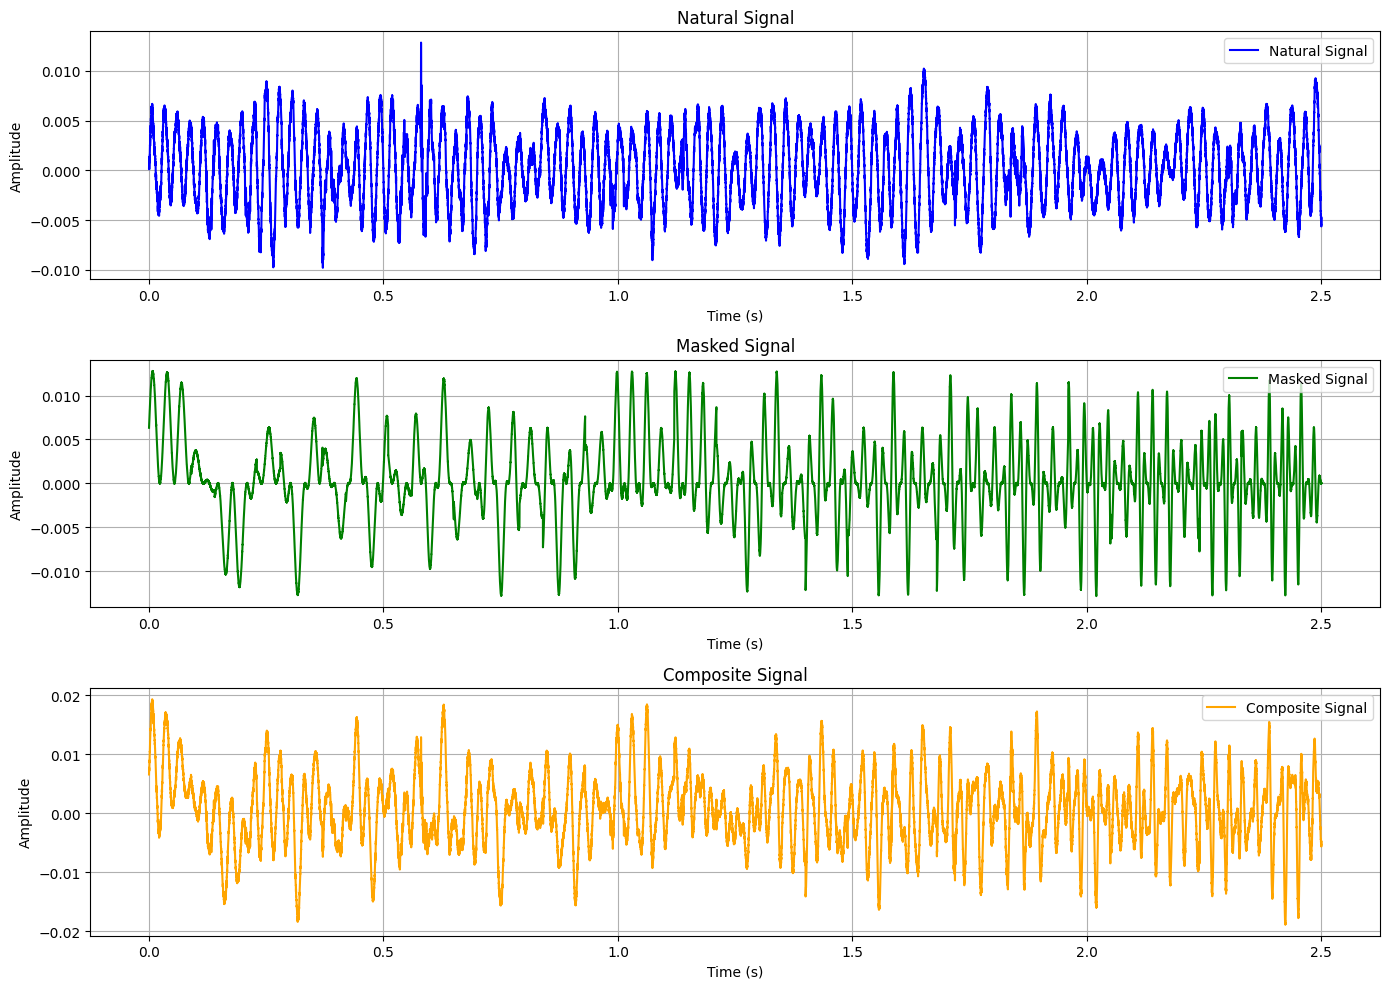

In [6]:
# Plot the signals
plt.figure(figsize=(14, 10))

# Plot natural signal
plt.subplot(3, 1, 1)
plt.plot(t, natural_signal, label='Natural Signal', color='blue')
plt.title('Natural Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot masked signal
plt.subplot(3, 1, 2)
plt.plot(t, masked_signal, label='Masked Signal', color='green')
plt.title('Masked Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot composite signal
plt.subplot(3, 1, 3)
plt.plot(t, combined_signal, label='Composite Signal', color='orange')
plt.title('Composite Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [10]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_metrics(natural_signal, combined_signal, masking_signal, sr):
    # Normalize the signals
    natural_signal = natural_signal / np.linalg.norm(natural_signal)
    masking_signal = masking_signal / np.linalg.norm(masking_signal)
    
     # Calculate SNR
    snr = 10 * np.log10(np.sum(natural_signal ** 2) / np.sum((combined_signal - natural_signal) ** 2))
    
    # Dynamic SNR adjustment (example: increasing masking signal amplitude based on SNR)
    # if snr < -30:
    #     masking_signal *= 1.5  # Increase amplitude if SNR is very low

    # Calculate SOI (Spectral Overlap Index)
    soi = np.sum(np.abs(fft(natural_signal)[:len(natural_signal)//2]) * 
                 np.abs(fft(masking_signal)[:len(masking_signal)//2])) / np.sum(np.abs(fft(natural_signal)[:len(natural_signal)//2]) ** 2)
    
    # Calculate PME (Peak Masking Effectiveness)
    # pme = np.sum(np.minimum(natural_signal, masking_signal)) / np.sum(natural_signal)
    
    # Calculate SSIM (Structural Similarity Index)
    # Specify the data_range for floating point signals
    try:
        ssim_value = ssim(natural_signal, masking_signal, win_size=3, data_range=1.0)
    except ValueError:
        # If the error occurs, use the default window size (7) that is safe for 1D
        ssim_value = ssim(natural_signal, masking_signal, win_size=7, data_range=1.0)
    
    # Return the calculated metrics
    return {
        "SNR (dB)": snr,
        "SOI": soi,
        # "PME": pme,
        "SSIM": ssim_value
    }


def spectral_overlap(natural_signal, masking_signal, fs):
    # Compute the spectrograms of both signals
    f_natural, t_natural, Sxx_natural = spectrogram(natural_signal, fs)
    f_masking, t_masking, Sxx_masking = spectrogram(masking_signal, fs)
    
    # Rescale the spectrograms to ensure the same frequency bins
    overlap_freqs = np.intersect1d(f_natural, f_masking)
    
    overlap_psd_natural = np.interp(overlap_freqs, f_natural, Sxx_natural.mean(axis=1))
    overlap_psd_masking = np.interp(overlap_freqs, f_masking, Sxx_masking.mean(axis=1))
    
    # Spectral Overlap Calculation
    overlap = np.sum(overlap_psd_natural * overlap_psd_masking) / np.sum(overlap_psd_natural)
    return overlap

# 2. Calculate Temporal Masking
def temporal_masking(natural_signal, masking_signal):
    # Calculate instantaneous energy of both signals (simplified as the square of the amplitude)
    energy_natural = np.square(natural_signal)
    energy_masking = np.square(masking_signal)
    
    # Define a masking threshold (e.g., 10 times the energy of the masking signal)
    threshold = 10 * energy_masking
    
    # Count how many points the masking signal exceeds the threshold
    temporal_masking_count = np.sum(energy_natural < threshold)
    
    return temporal_masking_count / len(natural_signal)

overlap = spectral_overlap(natural_signal, combined_signal, sr)
masking_effectiveness = temporal_masking(natural_signal,combined_signal)

print(f"Spectral Overlap: {overlap:.4f}")
print(f"Temporal Masking: {masking_effectiveness:.4f}")

metrics = calculate_metrics(natural_signal[:4000], combined_signal[:4000], masked_signal[:4000], sr)
print("Masking Effectiveness Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

Spectral Overlap: 0.0000
Temporal Masking: 0.9486
Masking Effectiveness Metrics:
SNR (dB): -0.95
SOI: 0.74
SSIM: 0.16


In [11]:
# Step 3: Process All .wav Files
metrics_list = []
wav_files = [f for f in os.listdir(AUDIO_FOLDER) if f.endswith('.wav') and INSECT_NAME in f]

for wav_file in wav_files:
    # Load natural signal
    natural_signal, _ = librosa.load(os.path.join(AUDIO_FOLDER, wav_file), sr=sr)
    natural_signal = natural_signal / np.max(np.abs(natural_signal))
    natural_signal = natural_signal[:1600]
    masked_signal = masked_signal[:1600]
    # Combine natural and masked signals
    combined_signal = natural_signal + masked_signal

    # Calculate Metrics
    metrics = calculate_metrics(natural_signal, combined_signal, masked_signal, sr)
    # overlap = spectral_overlap(natural_signal, combined_signal, SR)
    # temporal_effectiveness = temporal_masking(natural_signal, combined_signal)
    # metrics.update({
    #     # "Spectral Overlap": overlap,
    #     "Temporal Masking": temporal_effectiveness,
    # })
    metrics_list.append(metrics)

# Step 4: Aggregate Metrics
df_metrics = pd.DataFrame(metrics_list)
average_metrics = df_metrics.mean()

print("\nAverage Masking Effectiveness Metrics:")
for k, v in average_metrics.items():
    print(f"{k}: {v:.4f}")


Average Masking Effectiveness Metrics:
SNR (dB): -16.0049
SOI: 0.6873
SSIM: 0.2151


In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import chirp
# from skimage.metrics import structural_similarity as ssim
# import os
# import librosa
# import pandas as pd

# # Assuming df_filtered contains your dataset for analysis
# sound_profile = extract_sound_profile(df_filtered)

# # Step 3: Update parameters dynamically based on the extracted profile
# freq_range = sound_profile["Dominant Frequency Range"]
# mode_freq = sound_profile["Mode Frequency"]
# dominant_freq_mean = sound_profile["Dominant Frequency Mean"]
# amplitude_range = sound_profile["Amplitude Range"]
# zero_crossing_rate = sound_profile["Zero-Crossing Rate Mean"]

# # Burst durations and intervals
# NUM_HOPS = 25  # Adjust based on your simulation needs
# burst_durations = [0.075] * NUM_HOPS  # Assuming constant burst durations
# burst_intervals = [0.04] * NUM_HOPS  # Assuming constant burst intervals

# # Initialize dynamic adjustment parameters
# white_noise_strength = 0.35  # Starting value for white noise strength
# optimal_amplitude_range = amplitude_range  # Initial amplitude range

# # Time array
# t = np.linspace(0, duration, int(sr * duration), endpoint=False)

# def generate_masked_signal(amp_range, noise_strength):
#     global duration
#     # Time array
#     t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    
#     # Frequency modulation: Chirp signal (linear frequency change)
#     fm_signal = chirp(t, f0=0, f1=43, t1=duration, method='linear')
    
#     # Amplitude modulation: Randomize within the given range
#     amplitude_modulation = np.random.uniform(amp_range[0], amp_range[1], size=len(t))
    
#     # Modulate the chirp signal with amplitude modulation
#     am_signal = fm_signal + amplitude_modulation

#     # Add bursts to the signal
#     signal_with_bursts = np.zeros(len(t))
#     start_idx = 0
#     for interval, burst_duration in zip(burst_intervals, burst_durations):
#         end_idx = int(start_idx + burst_duration * sr)
#         signal_with_bursts[start_idx:end_idx] = am_signal[start_idx:end_idx]
#         start_idx = int(end_idx + interval * sr)
    
#     # Add white noise
#     white_noise = np.random.normal(0, noise_strength, len(t))
#     noise_signal = am_signal + white_noise
#     masked_signal = noise_signal + signal_with_bursts
    
#     # Normalize the signal to the range [-0.5, 0.5]
#     masked_signal = masked_signal / np.max(np.abs(masked_signal))
#     return masked_signal


# # Calculate metrics
# def calculate_metrics(natural_signal, combined_signal, masking_signal, sr):
#     # Normalize the signals
#     natural_signal = natural_signal / np.linalg.norm(natural_signal)
#     masking_signal = masking_signal / np.linalg.norm(masking_signal)
    
#     # Calculate SNR
#     snr = 10 * np.log10(np.sum(natural_signal ** 2) / np.sum((combined_signal - natural_signal) ** 2))
    
#     # Calculate SOI (Spectral Overlap Index)
#     soi = np.sum(np.abs(np.fft.fft(natural_signal)[:len(natural_signal)//2]) * 
#                  np.abs(np.fft.fft(masking_signal)[:len(masking_signal)//2])) / np.sum(np.abs(np.fft.fft(natural_signal)[:len(natural_signal)//2]) ** 2)
    
#     # Calculate SSIM
#     try:
#         ssim_value = ssim(natural_signal, masking_signal, win_size=3, data_range=1.0)
#     except ValueError:
#         ssim_value = ssim(natural_signal, masking_signal, win_size=7, data_range=1.0)
    
#     return {"SNR (dB)": snr, "SOI": soi, "SSIM": ssim_value}

# # Optimize the amplitude range and white noise strength to improve SSIM
# best_ssim = 0
# best_masked_signal = None
# for amp_adjustment in np.linspace(0.8, 1.2, 5):  # Adjust amplitude range
#     for noise_adjustment in np.linspace(0.005, 0.02, 5):  # Adjust noise strength
#         test_amp_range = (amplitude_range[0] * amp_adjustment, amplitude_range[1] * amp_adjustment)
#         masked_signal = generate_masked_signal(test_amp_range, noise_adjustment)
        
#         # Test on a random natural signal from the dataset
#         natural_signal, _ = librosa.load(os.path.join(AUDIO_FOLDER, wav_files[0]), sr=sr)
#         natural_signal = natural_signal / np.max(np.abs(natural_signal))
#         combined_signal = natural_signal[:1600] + masked_signal[:1600]

#         metrics = calculate_metrics(natural_signal[:1600], combined_signal, masked_signal[:1600], sr)
        
#         if metrics["SSIM"] > best_ssim:
#             best_ssim = metrics["SSIM"]
#             optimal_amplitude_range = test_amp_range
#             white_noise_strength = noise_adjustment
#             best_masked_signal = masked_signal

# # Step 4: Process all .wav files with the optimized parameters
# metrics_list = []
# for wav_file in wav_files:
#     natural_signal, _ = librosa.load(os.path.join(AUDIO_FOLDER, wav_file), sr=sr)
#     natural_signal = natural_signal / np.max(np.abs(natural_signal))
#     natural_signal = natural_signal[:1600]
#     masked_signal = best_masked_signal[:1600]
#     combined_signal = natural_signal + masked_signal

#     metrics = calculate_metrics(natural_signal, combined_signal, masked_signal, sr)
#     metrics_list.append(metrics)

# # Step 5: Aggregate and display the final metrics
# df_metrics = pd.DataFrame(metrics_list)
# average_metrics = df_metrics.mean()

# print("\nAverage Masking Effectiveness Metrics (Optimized for SSIM):")
# for k, v in average_metrics.items():
#     print(f"{k}: {v:.4f}")

In [12]:
import os
import librosa
import numpy as np
import scipy.io.wavfile as wav

# Define the path to save the composite signal
output_folder = '/home/aditya_tilak/dataset/Signals/'  # Change this to your desired folder
output_filename = 'Nezara_composite_signal.wav'  # You can change this name as needed
# Ensure the output path is in a valid UTF-8 format
output_filepath = os.path.join(output_folder, output_filename)

# Check if the file already exists
if os.path.exists(output_filepath):
    raise FileExistsError(f"Error: The file '{output_filepath}' already exists. Operation aborted.")

# Ensure that the composite signal is in the correct range for 16-bit PCM
combined_signal_int16 = np.int16(combined_signal / np.max(np.abs(combined_signal)) * 32767)

# Write to WAV file
try:
    wav.write(output_filepath, sr, combined_signal_int16)
    print(f"Composite signal saved to: {output_filepath}")
except UnicodeEncodeError:
    print(f"Error: The path or filename contains invalid characters. Please check and try again.")


Composite signal saved to: /home/aditya_tilak/dataset/Signals/Nezara_composite_signal.wav
